In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import urllib.request
import os
from sklearn.metrics import accuracy_score
import import_ipynb
from Adagrad import Adagrad
from GradaGrad import GradaGrad
from Adam import Adam
from SGD import SGD

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=100):
    model = LogisticRegressionModel(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optimizer_fn(model.parameters())

    accuracies = []

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            predictions = (outputs >= 0.5).float()
            accuracy = accuracy_score(y_train, predictions.numpy())
            accuracies.append(accuracy)

    with torch.no_grad():
        model.eval()
        inputs_test = torch.tensor(X_test, dtype=torch.float32)
        outputs_test = model(inputs_test)
        predictions_test = (outputs_test >= 0.5).float()
        test_accuracy = accuracy_score(y_test, predictions_test.numpy())

    return accuracies, test_accuracy

def grid_search_optimizer(X_train, y_train, X_test, y_test, optimizer_factory, lr_range, epochs):
    best_accuracy = 0
    best_lr = lr_range[0]

    for lr in lr_range:
        optimizer_fn = lambda params: optimizer_factory(params, lr=lr)
        accuracies, _ = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)

        avg_accuracy_last_10 = np.mean(accuracies[-10:])

        if avg_accuracy_last_10 > best_accuracy:
            best_accuracy = avg_accuracy_last_10
            best_lr = lr

    return best_lr, best_accuracy

epochs = 100
lr_range = [2**x for x in range(-10, 1)]  



optimizers_dict = {
    "AdaGrad": torch.optim.Adagrad,
    "Adam": Adam,
    "SGD": SGD,
    "GradaGrad": GradaGrad  
}

def make_optimizer_fn(name):
    if name == "GradaGrad":
        return lambda params: GradaGrad(params, gamma=1.0, rho=2.0, beta=0.9, G_inf=0.5, D_inf=100)
    else:
        return lambda params, lr: optimizers_dict[name](params, lr=lr)

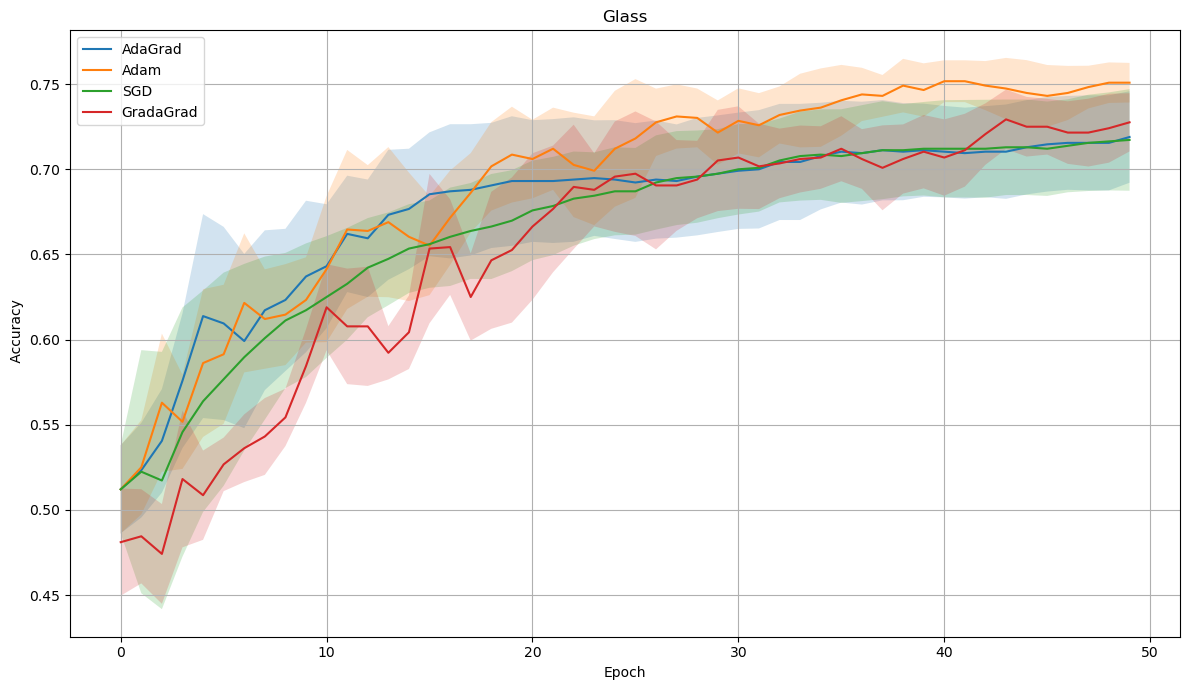

In [13]:
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/glass.scale"
filename = "glass.scale"
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

X, y = load_svmlight_file(filename)
y = y.astype(int)

class_0, class_1 = np.bincount(y).argsort()[-2:]
mask = np.isin(y, [class_0, class_1])
X, y = X[mask], y[mask]
X = X.toarray()
y = (y == class_1).astype(int)

plt.figure(figsize=(12, 7))

n_runs = 10
epochs = 50

for name in optimizers_dict.keys():

    all_accuracies = []

    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        if name == "GradaGrad":
            optimizer_fn = make_optimizer_fn(name)
        else:
            optimizer_factory = make_optimizer_fn(name)
            best_lr, _ = grid_search_optimizer(
                X_train, y_train, X_test, y_test,
                optimizer_factory, lr_range, epochs
            )
            optimizer_fn = lambda params: optimizer_factory(params, best_lr)

        accuracies, _ = train_logistic_regression(
            X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs
        )
        all_accuracies.append(accuracies)

    all_accuracies = np.array(all_accuracies)
    mean_accuracy = np.mean(all_accuracies, axis=0)
    std_error = np.std(all_accuracies, axis=0, ddof=1) / np.sqrt(n_runs)

    epochs_range = range(epochs)
    plt.plot(epochs_range, mean_accuracy, label=f'{name}')
    plt.fill_between(epochs_range,
                     mean_accuracy - 2 * std_error,
                     mean_accuracy + 2 * std_error,
                     alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel(' Accuracy')
plt.title('Glass')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

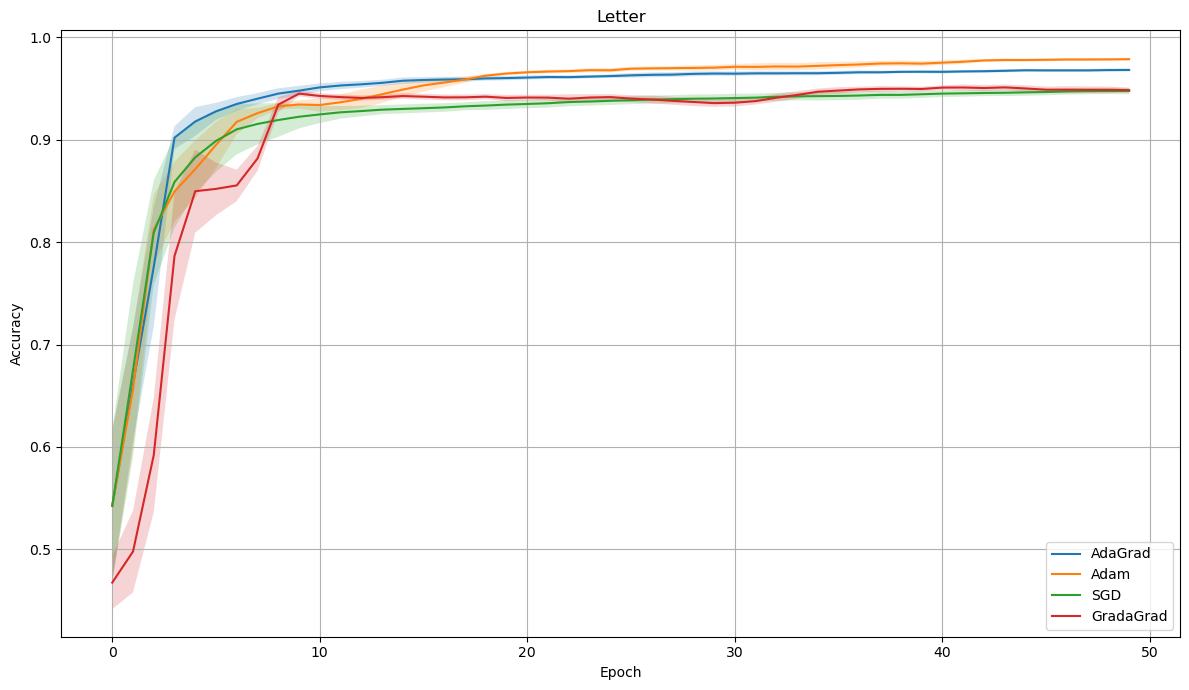

In [14]:
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/letter.scale"
filename = "letter.scale"
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

X, y = load_svmlight_file(filename)
y = y.astype(int)

class_0, class_1 = np.bincount(y).argsort()[-2:]
mask = np.isin(y, [class_0, class_1])
X, y = X[mask], y[mask]
X = X.toarray()
y = (y == class_1).astype(int)
plt.figure(figsize=(12, 7))

n_runs = 10
epochs = 50

for name in optimizers_dict.keys():

    all_accuracies = []

    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        if name == "GradaGrad":
            optimizer_fn = make_optimizer_fn(name)
        else:
            optimizer_factory = make_optimizer_fn(name)
            best_lr, _ = grid_search_optimizer(
                X_train, y_train, X_test, y_test,
                optimizer_factory, lr_range, epochs
            )
            optimizer_fn = lambda params: optimizer_factory(params, best_lr)

        accuracies, _ = train_logistic_regression(
            X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs
        )
        all_accuracies.append(accuracies)

    all_accuracies = np.array(all_accuracies)
    mean_accuracy = np.mean(all_accuracies, axis=0)
    std_error = np.std(all_accuracies, axis=0, ddof=1) / np.sqrt(n_runs)

    epochs_range = range(epochs)
    plt.plot(epochs_range, mean_accuracy, label=f'{name}')
    plt.fill_between(epochs_range,
                     mean_accuracy - 2 * std_error,
                     mean_accuracy + 2 * std_error,
                     alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Letter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

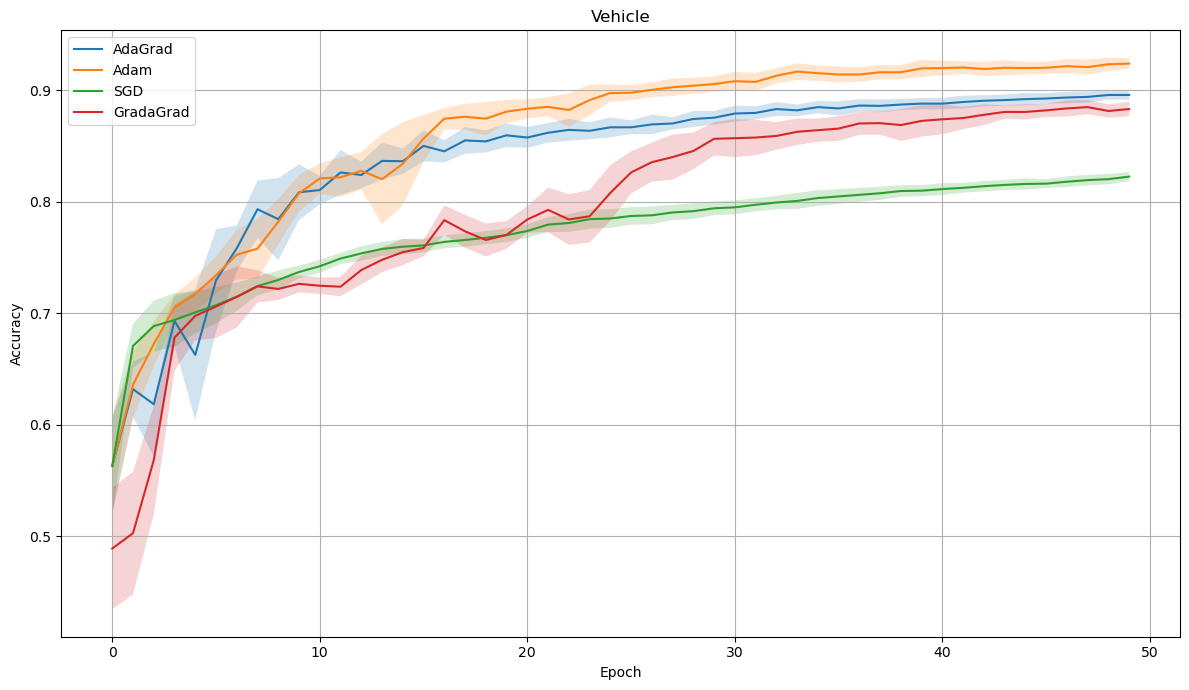

In [15]:
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/vehicle.scale"
filename = "vehicle.scale"
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

X, y = load_svmlight_file(filename)
y = y.astype(int)

class_0, class_1 = np.bincount(y).argsort()[-2:]
mask = np.isin(y, [class_0, class_1])
X, y = X[mask], y[mask]
X = X.toarray()
y = (y == class_1).astype(int)
plt.figure(figsize=(12, 7))

n_runs = 10
epochs = 50

for name in optimizers_dict.keys():

    all_accuracies = []

    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        if name == "GradaGrad":
            optimizer_fn = make_optimizer_fn(name)
        else:
            optimizer_factory = make_optimizer_fn(name)
            best_lr, _ = grid_search_optimizer(
                X_train, y_train, X_test, y_test,
                optimizer_factory, lr_range, epochs
            )
            optimizer_fn = lambda params: optimizer_factory(params, best_lr)

        accuracies, _ = train_logistic_regression(
            X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs
        )
        all_accuracies.append(accuracies)

    all_accuracies = np.array(all_accuracies)
    mean_accuracy = np.mean(all_accuracies, axis=0)
    std_error = np.std(all_accuracies, axis=0, ddof=1) / np.sqrt(n_runs)

    epochs_range = range(epochs)
    plt.plot(epochs_range, mean_accuracy, label=f'{name}')
    plt.fill_between(epochs_range,
                     mean_accuracy - 2 * std_error,
                     mean_accuracy + 2 * std_error,
                     alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Vehicle')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

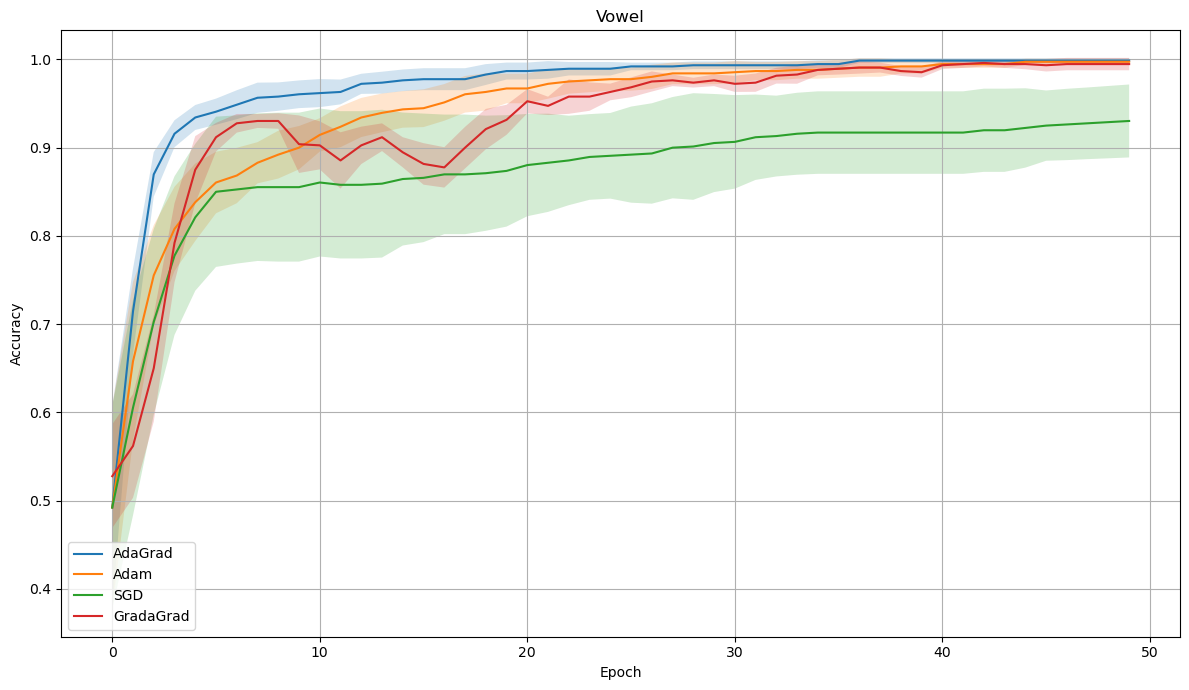

In [16]:
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/vowel.scale"
filename = "vowel.scale"
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

X, y = load_svmlight_file(filename)
y = y.astype(int)

class_0, class_1 = np.bincount(y).argsort()[-2:]
mask = np.isin(y, [class_0, class_1])
X, y = X[mask], y[mask]
X = X.toarray()
y = (y == class_1).astype(int)
plt.figure(figsize=(12, 7))

n_runs = 10
epochs = 50

for name in optimizers_dict.keys():

    all_accuracies = []

    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        if name == "GradaGrad":
            optimizer_fn = make_optimizer_fn(name)
        else:
            optimizer_factory = make_optimizer_fn(name)
            best_lr, _ = grid_search_optimizer(
                X_train, y_train, X_test, y_test,
                optimizer_factory, lr_range, epochs
            )
            optimizer_fn = lambda params: optimizer_factory(params, best_lr)

        accuracies, _ = train_logistic_regression(
            X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs
        )
        all_accuracies.append(accuracies)

    all_accuracies = np.array(all_accuracies)
    mean_accuracy = np.mean(all_accuracies, axis=0)
    std_error = np.std(all_accuracies, axis=0, ddof=1) / np.sqrt(n_runs)

    epochs_range = range(epochs)
    plt.plot(epochs_range, mean_accuracy, label=f'{name}')
    plt.fill_between(epochs_range,
                     mean_accuracy - 2 * std_error,
                     mean_accuracy + 2 * std_error,
                     alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Vowel')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

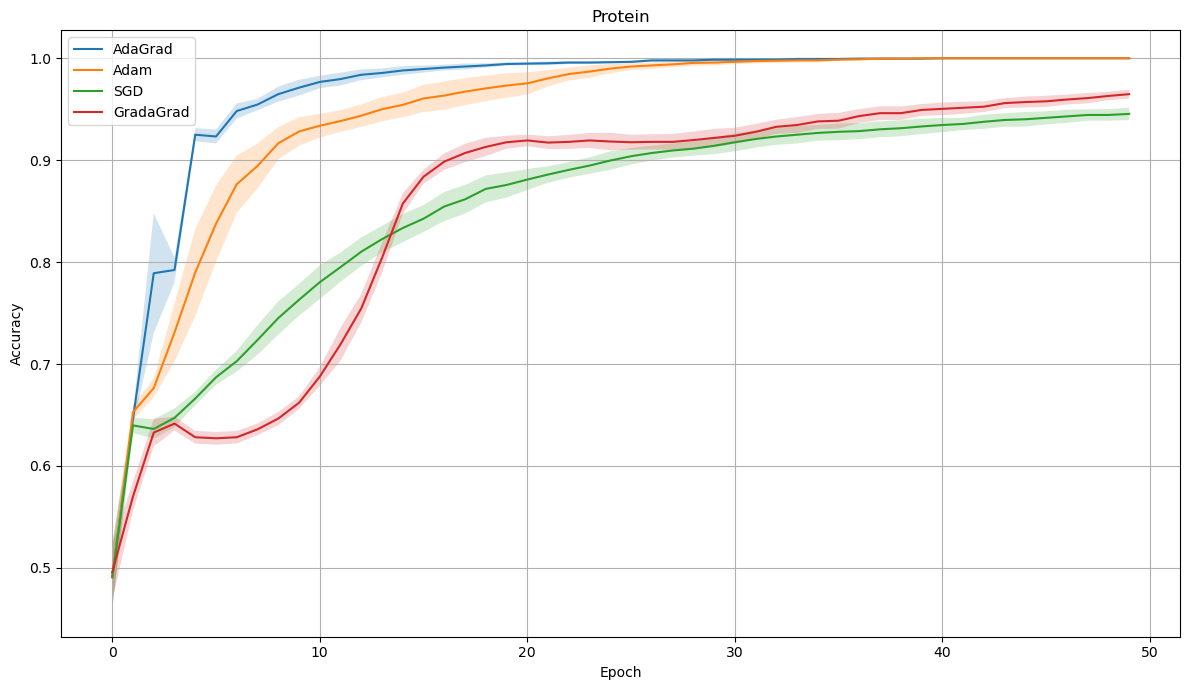

In [17]:
cleaned_lines = []
with open("protein", "r") as file:
    for line in file:
        if line.strip() == "":
            continue
        
        try:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            values = [float(x.split(":")[1]) for x in parts[1:]]  
            cleaned_lines.append(line)
        except ValueError:
            continue

with open("protein_cleaned", "w") as file:
    file.writelines(cleaned_lines)

from sklearn.datasets import load_svmlight_file

X, y = load_svmlight_file("protein_cleaned")
y = y.astype(int)

class_0, class_1 = np.bincount(y).argsort()[-2:]
mask = np.isin(y, [class_0, class_1])
X, y = X[mask], y[mask]
X = X.toarray()
y = (y == class_1).astype(int)
plt.figure(figsize=(12, 7))

n_runs = 10
epochs = 50

for name in optimizers_dict.keys():

    all_accuracies = []

    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        if name == "GradaGrad":
            optimizer_fn = make_optimizer_fn(name)
        else:
            optimizer_factory = make_optimizer_fn(name)
            best_lr, _ = grid_search_optimizer(
                X_train, y_train, X_test, y_test,
                optimizer_factory, lr_range, epochs
            )
            optimizer_fn = lambda params: optimizer_factory(params, best_lr)

        accuracies, _ = train_logistic_regression(
            X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs
        )
        all_accuracies.append(accuracies)

    all_accuracies = np.array(all_accuracies)
    mean_accuracy = np.mean(all_accuracies, axis=0)
    std_error = np.std(all_accuracies, axis=0, ddof=1) / np.sqrt(n_runs)

    epochs_range = range(epochs)
    plt.plot(epochs_range, mean_accuracy, label=f'{name}')
    plt.fill_between(epochs_range,
                     mean_accuracy - 2 * std_error,
                     mean_accuracy + 2 * std_error,
                     alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Protein')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

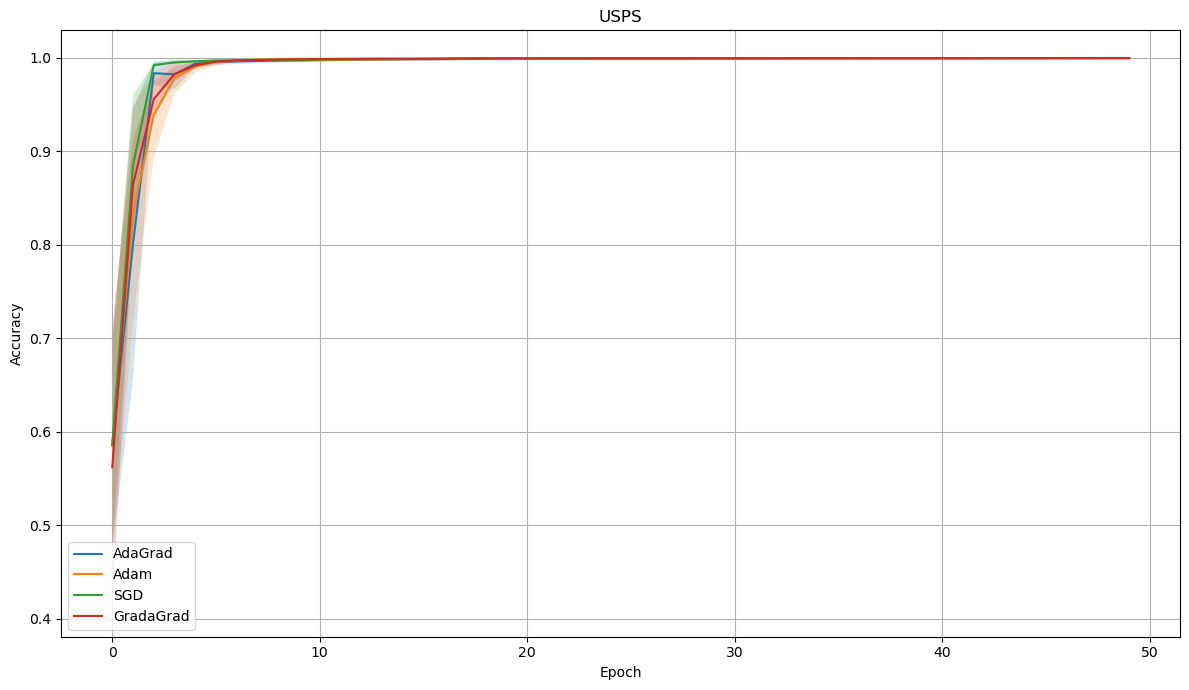

In [18]:
X, y = load_svmlight_file("usps")
y = y.astype(int)

class_0, class_1 = np.bincount(y).argsort()[-2:]
mask = np.isin(y, [class_0, class_1])
X, y = X[mask], y[mask]
X = X.toarray()
T=y
y = (y == class_1).astype(int)
plt.figure(figsize=(12, 7))

n_runs = 10
epochs = 50

for name in optimizers_dict.keys():

    all_accuracies = []

    for seed in range(n_runs):
        torch.manual_seed(seed)
        np.random.seed(seed)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        if name == "GradaGrad":
            optimizer_fn = make_optimizer_fn(name)
        else:
            optimizer_factory = make_optimizer_fn(name)
            best_lr, _ = grid_search_optimizer(
                X_train, y_train, X_test, y_test,
                optimizer_factory, lr_range, epochs
            )
            optimizer_fn = lambda params: optimizer_factory(params, best_lr)

        accuracies, _ = train_logistic_regression(
            X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs
        )
        all_accuracies.append(accuracies)

    all_accuracies = np.array(all_accuracies)
    mean_accuracy = np.mean(all_accuracies, axis=0)
    std_error = np.std(all_accuracies, axis=0, ddof=1) / np.sqrt(n_runs)

    epochs_range = range(epochs)
    plt.plot(epochs_range, mean_accuracy, label=f'{name}')
    plt.fill_between(epochs_range,
                     mean_accuracy - 2 * std_error,
                     mean_accuracy + 2 * std_error,
                     alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('USPS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()